$$
\newcommand{\dr}{\partial}
\newcommand{\dd}{\mathrm{d}}
\newcommand{\weffsq}{\tilde\omega_n^2 }
$$

In [2]:
from measurements import ConfResults, EnsembleResults

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import subprocess


# Free case

In this notebook we consider the free case

$$
\dr_t \phi = -\Gamma\left(-\Delta +m^2\right)\phi+ \xi
$$

with $\Delta \phi = \frac{1}{a}\left(\sum_i \phi_{+i}+\sum_i\phi_{-i}-6\phi\right)$. In Fourier space, this reads

$$
\begin{align}
\dr_t \phi_n &= -\Gamma(\tilde k_n^2+m^2)\phi_n + \xi\\
&=-\Gamma \tilde\weffsq\phi_n + \xi
\end{align}
$$

and $\tilde k$ is a lattice momentum $-\tilde k^2_n=\frac{2}{a}\left(\cos\left(\frac{2 \pi n }{N}\right) - 1\right)$.

### Forward Euler

$$
\begin{align}
\phi_n^s=\phi_n^{s-1}-\dd t \Gamma \weffsq\phi_n^{s-1} + W^s\dd t \\
\implies \phi_n^s = (1-\dd t \Gamma \weffsq)\phi_n^{s-1}+W^s\dd t 
\end{align}
$$

We can solve this recursion

$$
\begin{align}
\phi_n^1 &= W^1\dd t  \\ 
\phi_n^2 & = (1-\dd t \Gamma \weffsq)W^1\dd t +W^2\dd t  \\
\phi_n^S & = \sum_{s=1}^S ((1-\dd t \Gamma \weffsq)^{S-s})W^s\dd t  \ ,
\end{align}
$$

and compute moments. In particular, we get (the $W$s are independent)

$$
\begin{align}
\left<\phi_n^S \phi_{-n}^S\right> & =2\Gamma \dd t \sum_{s=1}^S (1-\dd t \Gamma \weffsq)^{2(S-s)}) \\
&=\frac{2}{\weffsq(2-\Gamma \weffsq dt)} \left(1-(1-\dd t \Gamma \weffsq)^{2S})\right)
\end{align}
$$

### Backward Euler

$$
\begin{align}
\phi_n^s=\phi_n^{s-1}-\dd t \Gamma \weffsq\phi_n^s + W^s\dd t \\
\implies \phi_n^s = \frac{1}{1+\dd t \Gamma \weffsq}\left(\phi_n^{s-1}+W^s\dd t \right)
\end{align}
$$

We can solve this recursion

$$
\begin{align}
\phi_n^1 &= \frac{W^1\dd t }{1+\dd t \Gamma \weffsq} \\ 
\phi_n^2 & = \frac{W^1\dd t }{(1+\dd t \Gamma \weffsq)^2} + \frac{W^2\dd t }{1+\dd t \Gamma \weffsq} \\
\phi_n^S & = \sum_{s=1}^S \frac{W^s\dd t }{(1+\dd t \Gamma \weffsq)^{S+1-s}} \ ,
\end{align}
$$

and compute moments. In particular, we get (the $W$s are independent)

$$
\begin{align}
\left<\phi_n^S \phi_{-n}^S\right> & =2\Gamma \dd t \sum_{s=1}^S \frac{1}{(1+\dd t \Gamma \weffsq)^{2(S+1-s)}} \\
&=\frac{2\Gamma \dd t}{2\dd t \Gamma \weffsq +\dd t^2 \Gamma^2 \tilde\omega_n^4 } \left(1-\frac{1}{(1+\dd t \Gamma \weffsq)^{2S}}\right)
\end{align}
$$


In [88]:
def free2ptBE(n, m2, dt, N, Γ=1, a=1, S=np.inf):
    kn2 = -2.0 / a * (np.cos((2.0 * np.pi) * n / N) - 1.0)
    ω2n = m2 + kn2
    
    
    res = 2 * Γ * dt / (2 * Γ * dt * ω2n + dt**2 * Γ**2 * ω2n**2)
    
    if not S==np.inf:
        res *=(1.0 - 1.0 /(1.0 + Γ * dt * ω2n )**(2.0*S) )
    
    return res

def free2ptFE(n, m2, dt, N, Γ=1, a=1, S=np.inf):
    kn2 = -2.0 / a * (np.cos((2.0 * np.pi * n) / N) - 1.0)
    ω2n = m2 + kn2
    
    
    res = 2.0 / ω2n  / (2.0  - dt * Γ * ω2n)
    
    if not S==np.inf:
        res *=(1.0 - (1.0 - Γ * dt * ω2n )**(2.0*S) )
    
    return res

def free2pt(n, m2, dt, N, Γ=1, a=1, S=np.inf):
    kn2 = -2.0 / a * (np.cos((2.0 * np.pi * n) / N) - 1.0)
    ω2n = m2 + kn2
    
    return 1.0 / ω2n
    

In [122]:
def runFreeModelA(eType, dt, nSteps, nSamples):
    final = nSteps * dt
    for i in range(nSamples):
        oname = "./freeCase/freeCase{}_{}".format("BE" if eType==1 else "FE", i)
        cmd = "mpirun -n 2 ModelA-Beuler.exe input=inputFree.in deltat={} finaltime={} saveFreq={} output={} evolverType={} seed={}".format(dt, final, dt, oname, eType,i)
        print(cmd,end="\r")
        subprocess.run(cmd.split(), stdout=subprocess.DEVNULL)

In [123]:
eType=2
dt=0.1
nSteps=50
nSamples=500
m2=0.25
N=8

!rm freeCase/*
runFreeModelA(eType,dt,nSteps,nSamples)

--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  ntgmac01.physics.sunysb.edu
  System call: unlink(2) /var/folders/fp/pwxfww_d0yx8cxh8f1z79_tc0000gr/T//ompi.ntgmac01.504/pid.9739/1/vader_segment.ntgmac01.504.94980001.0
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------


In [116]:
res = EnsembleResults("./freeCase/freeCaseFE",nSamples-1)
res.computeWallXFourierSquare0(0,50,1)

/Users/adrien/miniconda3/envs/Spyder/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/adrien/miniconda3/envs/Spyder/lib/python3.9/site-packages/numpy/ma/core.py:3374: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


<ErrorbarContainer object of 3 artists>

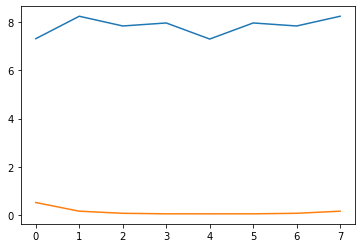

In [121]:
kn=[i for i in range(len(res.wallXFourierSquare0Err[-1]))]
fx = np.asarray([free2ptFE(k,m2,dt,N,S=nSteps+1) for k in kn])

plt.plot(fx/res.wallXFourierSquare0[-1])
plt.errorbar(kn,res.wallXFourierSquare0[-1],res.wallXFourierSquare0Err[-1])